# Dataset Statistics

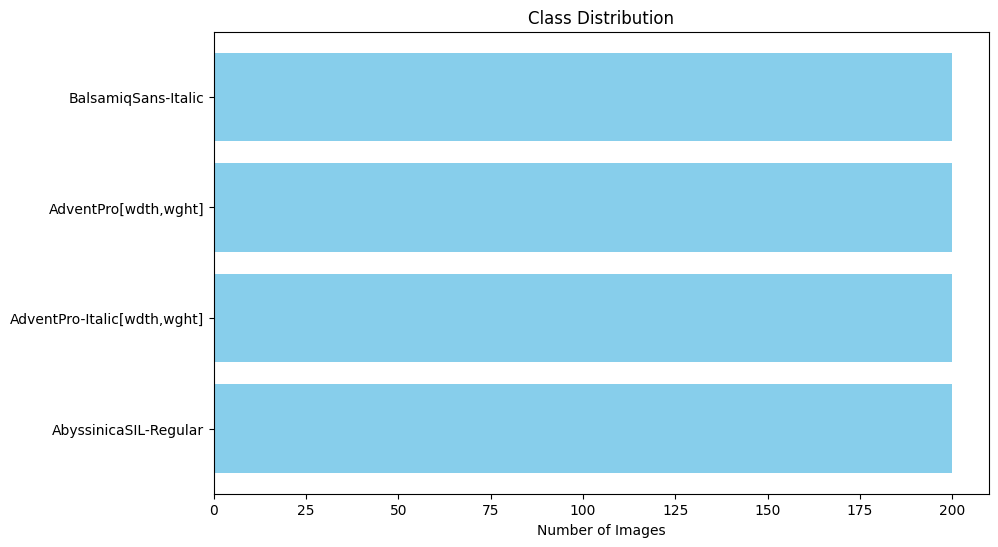

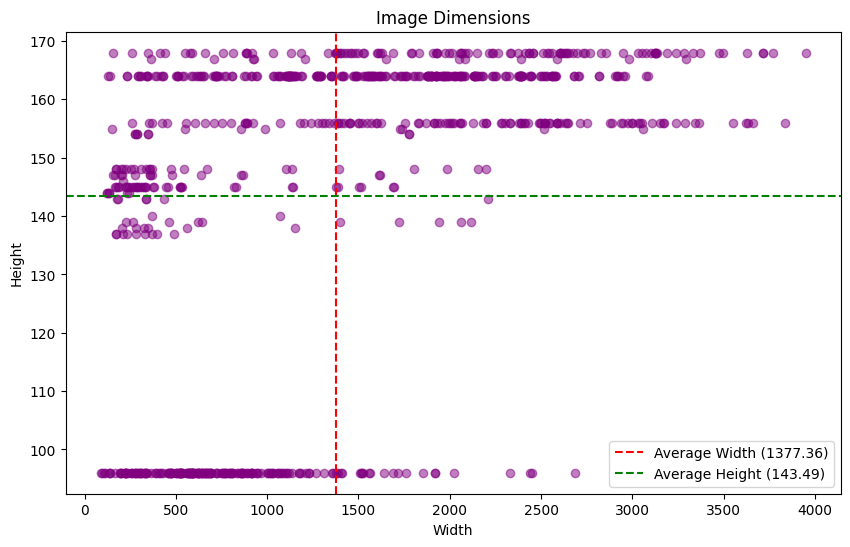

In [5]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import Counter
import torchvision.transforms as transforms
from fontClassifier import FontDataset
from torchvision import datasets

def get_dataset_statistics(root_dir):
    # Initialize lists to store image dimensions and class labels
    image_dims = []
    class_counts = Counter()

    # Iterate through the dataset folder to get statistics
    for class_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                if img_file.endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_dir, img_file)
                    # Get image dimensions
                    with Image.open(img_path) as img:
                        width, height = img.size
                        image_dims.append((width, height))
                    # Count class occurrences
                    class_counts[class_name] += 1

    # Calculate the average image dimensions
    avg_width = np.mean([dim[0] for dim in image_dims])
    avg_height = np.mean([dim[1] for dim in image_dims])

    return class_counts, image_dims, avg_width, avg_height


def visualize_class_distribution(class_counts):
    # Plot the class distribution
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.barh(classes, counts, color='skyblue')
    plt.xlabel('Number of Images')
    plt.title('Class Distribution')
    plt.show()


def visualize_image_dimensions(image_dims, avg_width, avg_height):
    # Plot the image dimensions
    widths = [dim[0] for dim in image_dims]
    heights = [dim[1] for dim in image_dims]

    plt.figure(figsize=(10, 6))
    plt.scatter(widths, heights, alpha=0.5, color='purple')
    plt.axvline(avg_width, color='red', linestyle='--', label=f'Average Width ({avg_width:.2f})')
    plt.axhline(avg_height, color='green', linestyle='--', label=f'Average Height ({avg_height:.2f})')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.title('Image Dimensions')
    plt.legend()
    plt.show()

# Example of how to use the functions
dataset_path = "Dataset"  # Replace with dataset path

# Get statistics of the dataset
class_counts, image_dims, avg_width, avg_height = get_dataset_statistics(dataset_path)

# Visualize the class distribution
visualize_class_distribution(class_counts)

# Visualize the image dimensions
visualize_image_dimensions(image_dims, avg_width, avg_height)

# Necessary Modules

In [1]:
import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from preprocessing import correct_skew, select_text_area, binarize_image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from fontClassifier import FontDataset, ResNet

# Preprocessing and data augmentation

In [2]:
# Ppreprocessing function
def preprocess_data(img):
    img = binarize_image(img)
    img, _ = correct_skew(img)
    img = select_text_area(img)
    # Ensure the output is a PIL Image
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img)
    return img

# Define transformations for data augmentation
train_transforms = transforms.Compose([
    transforms.Resize((64, 256)),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 256)),
    transforms.ToTensor()
])


# Dataset Preparation

In [3]:
# Define dataset path
dataset_path = "Dataset"

# Load the dataset without any transforms initially
original_dataset = FontDataset(root_dir=dataset_path, preprocess_func=preprocess_data)

# Split the dataset into train (80%), validation (10%), and test (10%) sets
train_size = int(0.8 * len(original_dataset))
val_size = int(0.1 * len(original_dataset))
test_size = len(original_dataset) - train_size - val_size

train_indices, val_indices, test_indices = random_split(range(len(original_dataset)), [train_size, val_size, test_size])

# Create subsets with different transforms
train_dataset = FontDataset(root_dir=dataset_path, preprocess_func=preprocess_data, transform=train_transforms)
val_dataset = FontDataset(root_dir=dataset_path, preprocess_func=preprocess_data, transform=test_transforms)
test_dataset = FontDataset(root_dir=dataset_path, preprocess_func=preprocess_data, transform=test_transforms)

# Subset datasets
train_dataset.data = [original_dataset.data[i] for i in train_indices.indices]
train_dataset.labels = [original_dataset.labels[i] for i in train_indices.indices]
val_dataset.data = [original_dataset.data[i] for i in val_indices.indices]
val_dataset.labels = [original_dataset.labels[i] for i in val_indices.indices]
test_dataset.data = [original_dataset.data[i] for i in test_indices.indices]
test_dataset.labels = [original_dataset.labels[i] for i in test_indices.indices]

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Data Visualization

In [14]:
import matplotlib.pyplot as plt
import torch

def visualize_data(loader, classes, num_images=5):
    """
    Visualize a few images and their corresponding labels from a DataLoader.

    Args:
    - loader (torch.utils.data.DataLoader): DataLoader to visualize.
    - classes (list): List of class names.
    - num_images (int): Number of images to visualize.
    """
    # Get a batch of data
    data_iter = iter(loader)
    images, labels = next(data_iter)

    # Create a figure for visualization
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0).numpy()  # Convert from CHW to HWC and NumPy array
        label = classes[labels[i].item()]
        axes[i].imshow(img)
        axes[i].set_title(label)
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()


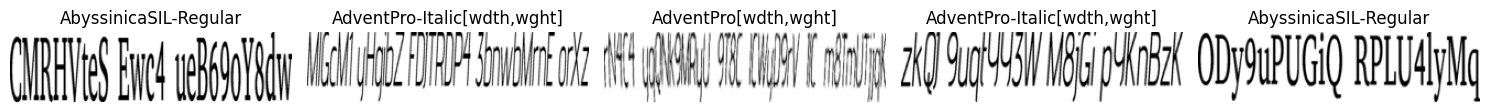

In [15]:
# Visualize training data
visualize_data(train_loader, train_dataset.classes)


# Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
from fontClassifier import ResNet

def compute_metrics(y_true, y_pred, average='macro'):
    """
    Compute accuracy, precision, recall, and F1 score.
    """
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred, average=average) * 100
    recall = recall_score(y_true, y_pred, average=average) * 100
    f1 = f1_score(y_true, y_pred, average=average) * 100
    return accuracy, precision, recall, f1

def train(model, train_loader, val_loader, test_loader, num_epochs=10, learning_rate=0.001, patience=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # Add weight decay
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # Reduce LR every 3 epochs

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    best_val_f1 = 0.0  # To track the best validation F1 score
    best_model_wts = None  # To store the best model weights
    early_stop_counter = 0  # Early stopping counter

    for epoch in range(num_epochs):
        # Training step
        model.train()
        running_loss = 0.0
        y_true_train, y_pred_train = [], []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(predicted.cpu().numpy())

            running_loss += loss.item()

        # Compute training metrics
        train_accuracy, train_precision, train_recall, train_f1 = compute_metrics(y_true_train, y_pred_train)

        # Validation step
        model.eval()
        val_loss = 0.0
        y_true_val, y_pred_val = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                y_true_val.extend(labels.cpu().numpy())
                y_pred_val.extend(predicted.cpu().numpy())

        # Compute validation metrics
        val_accuracy, val_precision, val_recall, val_f1 = compute_metrics(y_true_val, y_pred_val)

        # Save the best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_wts = model.state_dict()
            early_stop_counter = 0  # Reset early stopping counter
        else:
            early_stop_counter += 1

        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Train Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Precision: {train_precision:.2f}%, Recall: {train_recall:.2f}%, F1: {train_f1:.2f}%")
        print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%, "
              f"Precision: {val_precision:.2f}%, Recall: {val_recall:.2f}%, F1: {val_f1:.2f}%")

        # Early stopping
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

        # Step the scheduler
        scheduler.step()

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    # Evaluate on the test set
    model.eval()
    y_true_test, y_pred_test = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true_test.extend(labels.cpu().numpy())
            y_pred_test.extend(predicted.cpu().numpy())

    test_accuracy, test_precision, test_recall, test_f1 = compute_metrics(y_true_test, y_pred_test)
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Test Precision: {test_precision:.2f}%, Recall: {test_recall:.2f}%, F1 Score: {test_f1:.2f}%")

    # Save the best model to a file
    torch.save(best_model_wts, 'best_resnet_model.pth')
    print(f"Best model saved with validation F1 Score: {best_val_f1:.2f}%")

# Instantiate the model
model = ResNet(num_classes=4)

# Train the model
train(model, train_loader, val_loader, test_loader, num_epochs=10, learning_rate=0.001, patience=3)


# Training with wandb tracking

Epoch 1/10: 100%|██████████| 20/20 [02:12<00:00,  6.63s/it]
c:\Users\hasmo\miniconda3\envs\font\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/10]
Train Loss: 1.0517, Train Accuracy: 54.53%, Precision: 53.37%, Recall: 54.15%, F1: 53.72%
Validation Loss: 1.4927, Validation Accuracy: 45.00%, Precision: 26.10%, Recall: 42.71%, F1: 31.55%


Epoch 2/10: 100%|██████████| 20/20 [02:18<00:00,  6.91s/it]


Epoch [2/10]
Train Loss: 0.5670, Train Accuracy: 71.88%, Precision: 71.02%, Recall: 71.53%, F1: 70.91%
Validation Loss: 1.0106, Validation Accuracy: 45.00%, Precision: 52.88%, Recall: 46.53%, F1: 46.03%


Epoch 3/10: 100%|██████████| 20/20 [02:13<00:00,  6.67s/it]


Epoch [3/10]
Train Loss: 0.5467, Train Accuracy: 72.50%, Precision: 71.79%, Recall: 72.14%, F1: 71.93%
Validation Loss: 0.6881, Validation Accuracy: 70.00%, Precision: 76.50%, Recall: 70.62%, F1: 71.69%


Epoch 4/10: 100%|██████████| 20/20 [02:11<00:00,  6.59s/it]


Epoch [4/10]
Train Loss: 0.4470, Train Accuracy: 80.94%, Precision: 81.27%, Recall: 80.72%, F1: 80.32%
Validation Loss: 0.4334, Validation Accuracy: 82.50%, Precision: 83.82%, Recall: 83.82%, F1: 83.82%


Epoch 5/10: 100%|██████████| 20/20 [02:12<00:00,  6.63s/it]


Epoch [5/10]
Train Loss: 0.3911, Train Accuracy: 83.59%, Precision: 83.26%, Recall: 83.38%, F1: 83.23%
Validation Loss: 0.3934, Validation Accuracy: 87.50%, Precision: 89.67%, Recall: 87.64%, F1: 88.01%


Epoch 6/10: 100%|██████████| 20/20 [02:27<00:00,  7.37s/it]


Epoch [6/10]
Train Loss: 0.3125, Train Accuracy: 89.22%, Precision: 88.96%, Recall: 89.07%, F1: 88.97%
Validation Loss: 0.3149, Validation Accuracy: 88.75%, Precision: 90.27%, Recall: 89.03%, F1: 89.09%


Epoch 7/10: 100%|██████████| 20/20 [02:11<00:00,  6.56s/it]


Epoch [7/10]
Train Loss: 0.2351, Train Accuracy: 93.59%, Precision: 93.56%, Recall: 93.50%, F1: 93.49%
Validation Loss: 0.2559, Validation Accuracy: 91.25%, Precision: 91.98%, Recall: 91.53%, F1: 91.56%


Epoch 8/10: 100%|██████████| 20/20 [02:00<00:00,  6.03s/it]


Epoch [8/10]
Train Loss: 0.2304, Train Accuracy: 93.12%, Precision: 93.14%, Recall: 93.02%, F1: 93.02%
Validation Loss: 0.2471, Validation Accuracy: 92.50%, Precision: 92.64%, Recall: 92.78%, F1: 92.58%


Epoch 9/10: 100%|██████████| 20/20 [02:18<00:00,  6.94s/it]


Epoch [9/10]
Train Loss: 0.2372, Train Accuracy: 91.09%, Precision: 91.09%, Recall: 90.99%, F1: 91.01%
Validation Loss: 0.2384, Validation Accuracy: 91.25%, Precision: 91.31%, Recall: 91.53%, F1: 91.20%


Epoch 10/10: 100%|██████████| 20/20 [02:20<00:00,  7.03s/it]


Epoch [10/10]
Train Loss: 0.2126, Train Accuracy: 94.22%, Precision: 94.13%, Recall: 94.14%, F1: 94.13%
Validation Loss: 0.2350, Validation Accuracy: 91.25%, Precision: 91.58%, Recall: 91.53%, F1: 91.37%
Test Accuracy: 91.25%
Test Precision: 91.36%, Recall: 91.70%, F1 Score: 91.45%
Best model saved with validation F1 Score: 92.58%


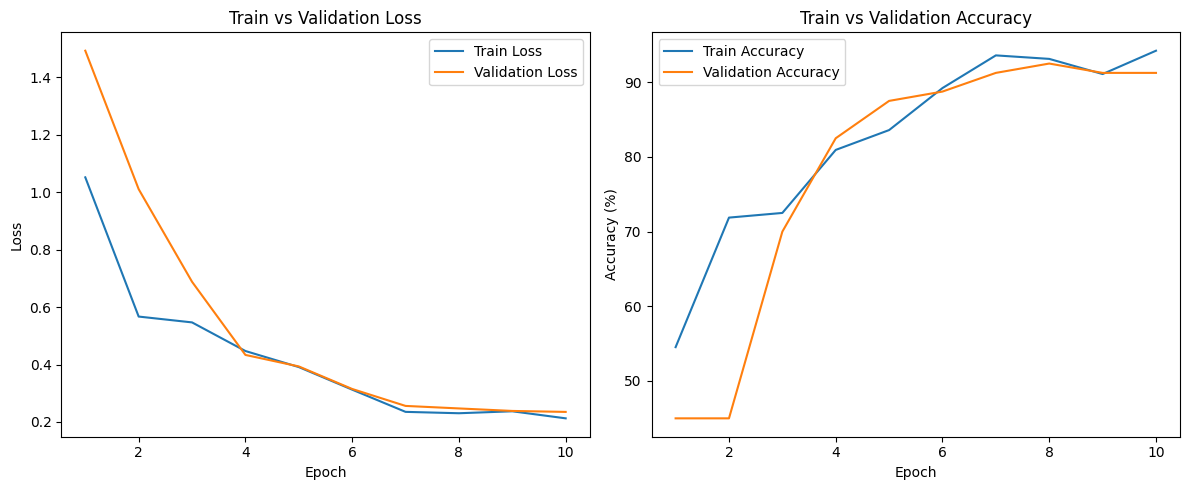

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▄▆▆▇██▇█
train_f1,▁▄▄▆▆▇██▇█
train_loss,█▄▄▃▂▂▁▁▁▁
train_precision,▁▄▄▆▆▇██▇█
train_recall,▁▄▄▆▆▇██▇█
val_accuracy,▁▁▅▇▇▇████
val_f1,▁▃▆▇▇█████
val_loss,█▅▄▂▂▁▁▁▁▁
val_precision,▁▄▆▇██████
val_recall,▁▂▅▇▇▇████


In [6]:
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from fontClassifier import ResNet

# Initialize a new wandb run
wandb.init(project='font-classifier', name='resnet-training-2')

def compute_metrics(y_true, y_pred, average='macro'):
    """
    Compute accuracy, precision, recall, and F1 score.
    """
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred, average=average) * 100
    recall = recall_score(y_true, y_pred, average=average) * 100
    f1 = f1_score(y_true, y_pred, average=average) * 100
    return accuracy, precision, recall, f1

def train(model, train_loader, val_loader, test_loader, num_epochs=10, learning_rate=0.001, patience=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # Add weight decay
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # Reduce LR every 3 epochs

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    best_val_f1 = 0.0  # To track the best validation F1 score
    best_model_wts = None  # To store the best model weights
    early_stop_counter = 0  # Early stopping counter

    # Metrics for visualization
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training step
        model.train()
        running_loss = 0.0
        y_true_train, y_pred_train = [], []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(predicted.cpu().numpy())

            running_loss += loss.item()

        # Compute training metrics
        train_accuracy, train_precision, train_recall, train_f1 = compute_metrics(y_true_train, y_pred_train)
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Validation step
        model.eval()
        val_loss = 0.0
        y_true_val, y_pred_val = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                y_true_val.extend(labels.cpu().numpy())
                y_pred_val.extend(predicted.cpu().numpy())

        # Compute validation metrics
        val_accuracy, val_precision, val_recall, val_f1 = compute_metrics(y_true_val, y_pred_val)
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        # Log metrics to wandb
        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_losses[-1],
            'val_loss': val_losses[-1],
            'train_accuracy': train_accuracy,
            'val_accuracy': val_accuracy,
            'train_precision': train_precision,
            'val_precision': val_precision,
            'train_recall': train_recall,
            'val_recall': val_recall,
            'train_f1': train_f1,
            'val_f1': val_f1
        })

        # Save the best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_wts = model.state_dict()
            early_stop_counter = 0  # Reset early stopping counter
        else:
            early_stop_counter += 1

        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Precision: {train_precision:.2f}%, Recall: {train_recall:.2f}%, F1: {train_f1:.2f}%")
        print(f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%, "
              f"Precision: {val_precision:.2f}%, Recall: {val_recall:.2f}%, F1: {val_f1:.2f}%")

        # Early stopping
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

        # Step the scheduler
        scheduler.step()

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    # Evaluate on the test set
    model.eval()
    y_true_test, y_pred_test = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true_test.extend(labels.cpu().numpy())
            y_pred_test.extend(predicted.cpu().numpy())

    test_accuracy, test_precision, test_recall, test_f1 = compute_metrics(y_true_test, y_pred_test)
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Test Precision: {test_precision:.2f}%, Recall: {test_recall:.2f}%, F1 Score: {test_f1:.2f}%")

    # Save the best model to a file
    torch.save(best_model_wts, 'best_resnet_model.pth')
    print(f"Best model saved with validation F1 Score: {best_val_f1:.2f}%")

    # Plotting the metrics
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Train vs Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Finish wandb run
    wandb.finish()

# Instantiate the model
model = ResNet(num_classes=4)

# Train the model
train(model, train_loader, val_loader, test_loader, num_epochs=10, learning_rate=0.001, patience=3)


# Saving the model weight

In [15]:
train_dataset.classes

['AbyssinicaSIL-Regular',
 'AdventPro-Italic[wdth,wght]',
 'AdventPro[wdth,wght]',
 'BalsamiqSans-Italic']

# Inference Pipeline

In [30]:
import torch
from torchvision import transforms
from PIL import Image

# class labels
class_names = ['AbyssinicaSIL-Regular', 'AdventPro-Italic[wdth,wght]', 'AdventPro[wdth,wght]', 'BalsamiqSans-Italic']

# Load the saved model
def load_model(model, filename='resnet_trained.pth'):
    model.load_state_dict(torch.load(filename))
    model.eval()  # Set the model to evaluation mode
    return model

# Preprocess the image to match input size and transformations used during training
def preprocess_image(img):
    img = binarize_image(img)
    img, _ = correct_skew(img)
    img = select_text_area(img)
    # Ensure the output is a PIL Image
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img)
    return img

preprocess = transforms.Compose([
        transforms.Resize((64, 256)),  # Ensure image size matches input size (64x256)
        transforms.ToTensor()
    ])

# Inference function
def predict(image_path, model, class_names):
    img = Image.open(image_path)
    image = preprocess_image(img)
    image = preprocess(image)  # Apply preprocessing transformations
    image = image.unsqueeze(0)  # Add batch dimension (1, C, H, W)

    # Make the prediction
    with torch.no_grad():  # No need to track gradients during inference
        output = model(image)
    
    # Get the predicted class label (index)
    _, predicted_class = torch.max(output, 1)
    
    # Get the class name
    predicted_label = class_names[predicted_class.item()]
    
    print(f'Predicted label: {predicted_label}')
    return predicted_label

# Load the model
model = ResNet(num_classes=4)
model = load_model(model, filename='best_resnet_model.pth')

# Predict on a single image
image_path = 'textImg.png'
predicted_label = predict(image_path, model, class_names)


Predicted label: BalsamiqSans-Italic


C:\Users\hasmo\AppData\Local\Temp\ipykernel_3036\2715737478.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename))
